In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# initialise random number generator for later
rng = np.random.default_rng(42)

# Reinforcement Learning Coursework

## 1. Simple Q-Learning example

The idea is for the agent to travel from home (cell 6) to work (buiding robots of course - cell 35). The agent wants to get to work quickly, buy some croissants for breakfast and collect some cogs to build the robots with. When walking the robot can move to adjacent squares in one time step. It cannot cross walls - marked with heavy lines. It can take the tube which transports it from circle to circle on the red or blue lines in one time step. Falling in the pond is really unpleasant and should probably be avoided.

Rewards are as follows:
* Cell 35: +30
* Cell 10: +15 for first visit, -1 for subsequent visits
* Cell 32: +15 for first visit, -1 for subsequent visits
* Cell 16: and 27: -10
* All other cells: -1

There will therefore be 4 reward matrices conditional on whether cells 11 and 33 have been visited or not.

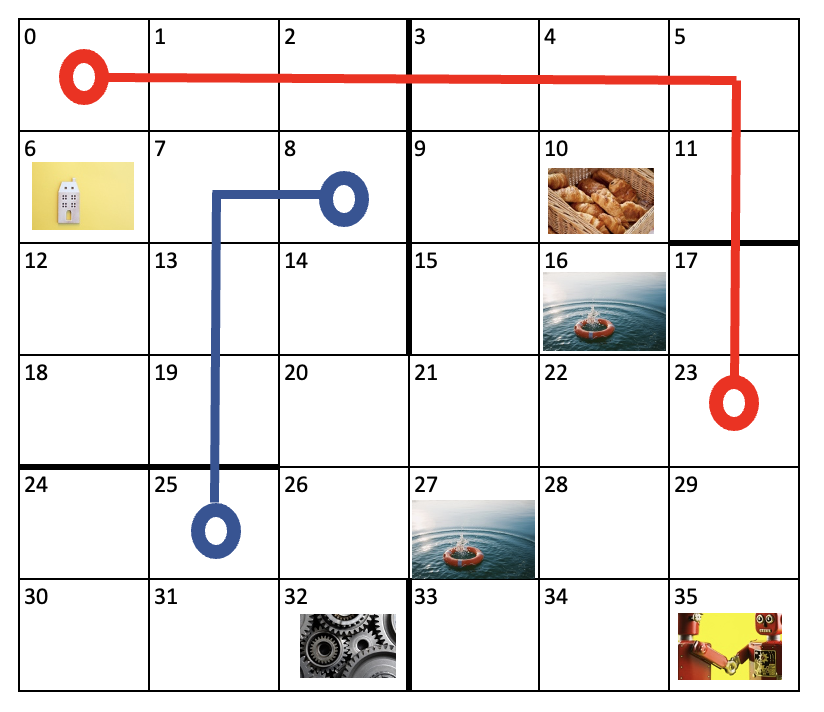

### Define reward matrices R

In [2]:
# R-initial
Ri = np.ones(shape=(36,36)) * np.nan
# Just in case we want to change rewards later - set them up as variables here:
r_time = -1
r_pond = -15
r_croissant = 200
r_cogs = 200
r_work = 15

# All moves where reward is -1 for action. Generate programmatically cos writing by hand is tedious
ones = []
for i in range(6):
    for j in range(6):
        cell = i*6 + j
        if j != 5:
            ones.append((cell, cell+1)) # move right unless agent is on right edge
        if cell - 6 >= 0:
            ones.append((cell, cell-6)) # move up if not in top row
        if cell + 6 < 36:
            ones.append((cell, cell+6)) # move down if cell not in bottom row
        if j != 0:
            ones.append((cell, cell-1)) # move left if not on left edge
        ones.append((cell, cell)) # staying still is possible, why not?
# add tube lines
ones.extend([(0,23), (23,0), (8,25), (25,8)])
ones = tuple(zip(*ones))
Ri[ones] = r_time

# now dissallow moves across walls. Just dissallow moves one way across a wall...
nans = [(2,3), (8,9), (14,15), (18, 24), (19,25), (32,33), (11,17)]
# ... and now dissallow moves the other way:
nans.extend([(t[1], t[0]) for t in nans])
Ri[tuple(zip(*nans))] = np.nan

def move_to(l, cell):
    for i in [-6, -1, 1, 6]:
        l.append((cell + i, cell))
    return l

# don't fall in the pond!
ponds = move_to(move_to([], 16), 27)
# staying in the pond is also pretty unpleasant. Brrrr!
ponds.extend([(16,16), (27,27)])
ponds = tuple(zip(*ponds))
Ri[ponds] = r_pond

# nice to eat a croissant before work
crois = move_to([], 10)
crois = tuple(zip(*crois))
Ri[crois] = r_croissant

# finally we write something by hand!
Ri[(26, 31), (32, 32)] = r_cogs

Ri[(29, 34, 35), (35, 35, 35)] = r_work

##########
# Now we have our reward matrix, we make three new reward matrices
# which don't have rewards for visiting cogs or croissants if they
# have already been visited
##########

# visited croissant but not cog
Rc = Ri.copy()
Rc[crois] = r_time

# visited cog but not croissant
Rg = Ri.copy()
Rg[(26, 31), (32, 32)] = r_time

# visited cog and croissant
Rb = Rg.copy()
Rb[crois] = r_time

### Visualise reward matrix

Can speciy first cell and last cell to slice R, so that certain parts can be seen easily

In [3]:
def display_R(start=None, end=None):
    pd.set_option("display.max_columns", None)
    display(pd.DataFrame(Ri).loc[start:end, start:end])
    
display_R(25,None)

,25,26,27,28,29,30,31,32,33,34,35
25,-1.0,-1.0,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN
26,-1.0,-1.0,-15.0,NaN,NaN,NaN,NaN,200.0,NaN,NaN,NaN
27,NaN,-1.0,-15.0,-1.0,NaN,NaN,NaN,NaN,-1.0,NaN,NaN
28,NaN,NaN,-15.0,-1.0,-1.0,NaN,NaN,NaN,NaN,-1.0,NaN
29,NaN,NaN,NaN,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,15.0
30,NaN,NaN,NaN,NaN,NaN,-1.0,-1.0,NaN,NaN,NaN,NaN
31,-1.0,NaN,NaN,NaN,NaN,-1.0,-1.0,200.0,NaN,NaN,NaN
32,NaN,-1.0,NaN,NaN,NaN,NaN,-1.0,-1.0,NaN,NaN,NaN
33,NaN,NaN,-15.0,NaN,NaN,NaN,NaN,NaN,-1.0,-1.0,NaN
34,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,-1.0,-1.0,15.0


## Function for Q-learning

Takes hyper parameters as inputs and saves results to numpy array.
For this task we do not save number of steps as the number of steps vs postive reward tradeoff is explicitly encoded in the rewards.

In [4]:
def Q_learning(Ri, Rc, Rg, Rb, alpha = 1, gamma = 0.8, epsilon = 0.9,
               epsilon_decay_1 = 1, epsilon_decay_2 = 1,
               epsilon_decay_threshold = 0.5, episodes=1000):

    # Q matrix
    Q = np.zeros(Ri.shape)
    
    # Define reward matrix as a numpy array. 
    # If croissant or cogs have been visited, the croissant or cogs index
    # changes from 0 to 1 and so the appropriate reward matrix is used
    R_ar = np.array([[Ri, Rc], [Rg, Rb]])
    goal_state = 35
    
    # array to hold performance metrics
    Qs = np.zeros(shape = Q[np.newaxis].shape)
    Rtot = np.array([])

    # Run for episodes
    for episode in range(episodes):
        
        # agent always starts at home
        s = 6
        # try starting agent from random location:
        # s = rng.choice(36)
        
        # set croissant and cogs as unvisited:
        idx_c = 0
        idx_g = 0
        
        # start a counter to find total reward earnt over the episode
        Rtot = np.concatenate((Rtot, np.zeros(1)))

        for timestep in range(500):
            
            # Choose appropriate reward matrix
            R = R_ar[idx_g, idx_c]
            
            # Action selection
            available_actions = np.where(~np.isnan(R[s]))[0]
            q_values = [Q[s,a] for a in available_actions]
            best_actions = available_actions[np.where(q_values == np.max(q_values))[0]]
            best_actions_q_values = [Q[s,x] for x in best_actions]

            # Epsilon-greedy
            if rng.uniform() > epsilon:
                a = rng.choice(best_actions)
            else:
                a = rng.choice(available_actions)

            # Environment updating
            r = R[s,a]
            s_old = s
            s = a 

            # Q value updating
            Q[s_old,a] = Q[s_old, a] + alpha * (r + gamma * Q[s, :].max() - Q[s_old, a])
            
            # update reward earned for this episode
            Rtot[-1] += r
                
            # note if croissant or cog have been visited
            if s == 10:
                idx_c = 1
            if s == 32:
                idx_g = 1

            if s == goal_state:
                break
        
        # Update epsilon after each episode
        if epsilon > epsilon_decay_threshold:
            epsilon *= epsilon_decay_1
        else:
            epsilon *= epsilon_decay_2
        Qs = np.concatenate((Qs, Q[np.newaxis]), axis=0)
        
                
    return Qs, Rtot

final Q matrix is:



,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
20,107,85,0,0,0,0,101,0,0,0,0,0,0,0,0,0
21,104,104,85,0,0,0,0,70,0,0,0,0,0,0,0,0
22,0,85,82,85,0,0,0,0,82,0,0,0,0,0,0,0
23,0,0,104,82,0,0,0,0,0,71,0,0,0,0,0,0
24,0,0,0,0,61,125,0,0,0,0,77,0,0,0,0,0
25,0,0,0,0,72,125,101,0,0,0,0,99,0,0,0,0
26,107,0,0,0,0,100,104,68,0,0,0,0,104,0,0,0
27,0,104,0,0,0,0,104,70,82,0,0,0,0,73,0,0
28,0,0,104,0,0,0,0,68,82,66,0,0,0,0,65,0
29,0,0,0,83,0,0,0,0,82,66,0,0,0,0,0,15


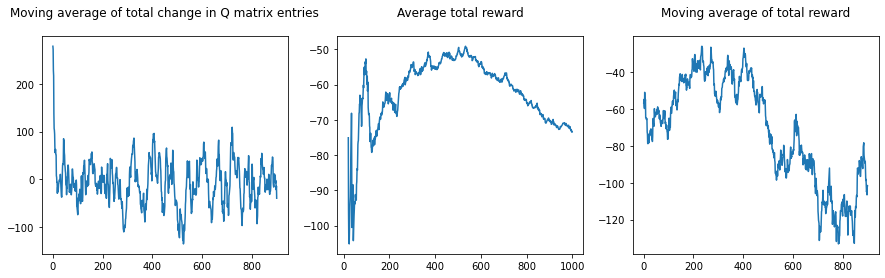

In [5]:
Qs, Rtot = Q_learning(Ri, Rc, Rg, Rb, alpha = 0.9, gamma = 0.8, epsilon = 1.0,
               epsilon_decay_1 = 0.9999, epsilon_decay_2 = 0.999,
               epsilon_decay_threshold = 0.5, episodes=1000)

Q_change = np.diff(Qs.sum(axis=(1,2)))

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

Q_change_ma = moving_average(Q_change, 100)
Rtot_ma = moving_average(Rtot, 100)
Rtot_avg = Rtot.cumsum() / np.arange(1, len(Rtot) + 1)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,4))

ax1.plot(Q_change_ma)
# ax1.set_yscale('log')
ax1.set_title('Moving average of total change in Q matrix entries', fontsize=12, pad=20)

ax2.plot(np.arange(20, len(Rtot_avg)), Rtot_avg[20:])
ax2.set_title('Average total reward', fontsize=12, pad=20)

ax3.plot(Rtot_ma)
ax3.set_title('Moving average of total reward', fontsize=12, pad=20)

print("final Q matrix is:\n")
display(pd.DataFrame(Qs[-1]).loc[20:,20:].style.format(precision=0))
print("")

In [6]:
Rtot.shape

(1000,)

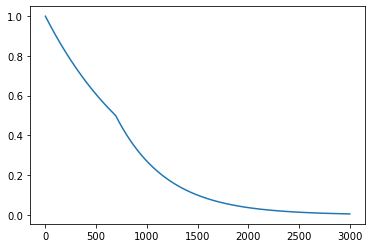

In [7]:
x = np.arange(3000)
epsilon=1
thresh = 0.5
d1 = np.ones(3000) * 0.999
d2 = np.ones(3000) * 0.998
d1c = d1.cumprod()
d2c = d2.cumprod()

y = d1c * epsilon
thresh_idx = np.argmax(y < thresh)
y[thresh_idx:] = y[thresh_idx] * d2c[thresh_idx:] / d2c[thresh_idx]

plt.plot(x,y);

In [8]:
alpha = 1
gamma = 0.8
epsilon = 0.0

# Q matrix
Q = Qs[-1] # initialise with the final trained Q-matrix

# Define reward matrix as a numpy array. 
# If croissant or cogs have been visited, the croissant or cogs index
# changes from 0 to 1 and so the appropriate reward matrix is used
R_ar = np.array([[Ri, Rc], [Rg, Rb]])
goal_state = 35
s = 6 # starting state

idx_g = 0
idx_c = 0

action_list = []

for timestep in range(500):
            
    # Choose appropriate reward matrix
    R = R_ar[idx_g, idx_c]

    # Action selection
    available_actions = np.where(~np.isnan(R[s]))[0]
    q_values = [Q[s,a] for a in available_actions]
    best_actions = available_actions[np.where(q_values == np.max(q_values))[0]]
    best_actions_q_values = [Q[s,x] for x in best_actions]

    # Epsilon-greedy
    if rng.uniform() > epsilon:
        a = rng.choice(best_actions)
    else:
        a = rng.choice(available_actions)

    # Environment updating
    r = R[s,a]
    s_old = s
    s = a
    action_list.append(a)

    # Q value updating
    Q[s_old,a] = Q[s_old, a] + alpha * (r + gamma * Q[s, :].max() - Q[s_old, a])

    # update reward earned for this episode
    Rtot[-1] += r

    # note if croissant or cog have been visited
    if s == 10:
        idx_c = 1
    if s == 32:
        idx_g = 1

    if s == goal_state:
        break



In [9]:
print(action_list)

[7, 8, 25, 25, 26, 20, 20, 26, 32, 26, 32, 26, 32, 26, 32, 32, 31, 32, 31, 25, 31, 31, 30, 31, 30, 24, 25, 25, 26, 26, 25, 8, 25, 26, 20, 19, 20, 19, 19, 20, 14, 20, 20, 21, 20, 14, 8, 14, 14, 14, 8, 8, 14, 13, 14, 13, 19, 20, 21, 21, 15, 9, 10, 9, 10, 9, 10, 9, 10, 9, 15, 21, 22, 23, 17, 17, 23, 22, 21, 21, 27, 26, 32, 26, 26, 20, 21, 27, 21, 27, 28, 22, 23, 17, 17, 23, 23, 29, 23, 22, 22, 28, 28, 27, 28, 29, 28, 22, 16, 22, 16, 17, 16, 10, 9, 9, 15, 15, 9, 15, 16, 15, 21, 15, 15, 21, 22, 23, 0, 23, 17, 17, 23, 29, 29, 23, 0, 0, 1, 7, 8, 7, 7, 13, 13, 7, 13, 19, 19, 13, 14, 13, 19, 18, 19, 18, 19, 20, 26, 32, 32, 31, 25, 25, 8, 8, 25, 31, 32, 32, 26, 27, 33, 33, 34, 28, 34, 33, 27, 27, 26, 32, 31, 31, 25, 24, 25, 26, 25, 24, 30, 24, 30, 30, 31, 31, 30, 24, 24, 30, 30, 24, 25, 25, 31, 25, 24, 25, 26, 20, 19, 20, 14, 20, 20, 26, 26, 20, 21, 20, 20, 14, 8, 2, 8, 2, 2, 1, 0, 1, 7, 7, 6, 7, 6, 0, 6, 6, 12, 13, 12, 18, 18, 19, 19, 20, 21, 21, 15, 21, 22, 16, 16, 10, 16, 17, 16, 10, 11, 11, 